In [1]:
%load_ext autoreload
%autoreload 2

In [230]:
import re
from typing import Dict, List, Tuple, Set

import torch
import torch.optim as optim
from allennlp.common.file_utils import cached_path
from allennlp.common.util import START_SYMBOL, END_SYMBOL
from allennlp.data import DataLoader
from allennlp.data.fields import TextField
from allennlp.data.instance import Instance
from allennlp.data.token_indexers import TokenIndexer, SingleIdTokenIndexer
from allennlp.data.tokenizers import Token, CharacterTokenizer
from allennlp.data.vocabulary import Vocabulary, DEFAULT_PADDING_TOKEN
from allennlp.models import Model
from allennlp.modules.seq2seq_encoders import PytorchSeq2SeqWrapper
from allennlp.modules.text_field_embedders import TextFieldEmbedder, BasicTextFieldEmbedder
from allennlp.modules.token_embedders import Embedding
from allennlp.nn.util import get_text_field_mask, sequence_cross_entropy_with_logits
from allennlp.training.trainer import GradientDescentTrainer
from allennlp.common.util import ensure_list
from allennlp.data.data_loaders import MultiProcessDataLoader
import torch.nn as nn

In [3]:
import sys
sys.path.insert(0, '../')
from readers.name_reader import NameReader

In [4]:
reader = NameReader()
instances = reader.read('../data/first_names.all.txt')
instances = ensure_list(instances)

In [5]:
instances[0].fields

{'tokens': <allennlp.data.fields.text_field.TextField at 0x159946500>}

# Modelling

In [231]:
class RNNLanguageModel(Model):
    def __init__(self, 
                embedder: TextFieldEmbedder,
                hidden_size: int,
                max_len: int,
                vocab: Vocabulary)->None:
        super().__init__(vocab)
        self.embedder = embedder
        
        self.rnn = PytorchSeq2SeqWrapper(
            torch.nn.LSTM(EMBEDDING_SIZE, HIDDEN_SIZE, batch_first=True))
        
        self.hidden2out = torch.nn.Linear(in_features = self.rnn.get_output_dim(), out_features = vocab.get_vocab_size('tokens'))
        
        self.hidden_size = hidden_size
        self.dropout = nn.Dropout(0.2)
        self.max_len = max_len
        

    def forward(self,tokens):
        mask = get_text_field_mask(tokens)

        embeddings = self.embedder(tokens)
        rnn_hidden = self.rnn(embeddings, mask)
        rnn_hidden = self.dropout(rnn_hidden)
        out_logits = self.hidden2out(rnn_hidden)

        # get output tokens
        token_ids = tokens['tokens']['tokens']
        forward_targets = torch.zeros_like(token_ids)
        forward_targets[:, 0:-1] = token_ids[:, 1:]
            
        loss = sequence_cross_entropy_with_logits(out_logits, forward_targets, mask)
        
        return {'loss': loss}
    
    def generate(self, initial_chars=None)-> Tuple[List[Token], torch.tensor]:
        start_symbol_idx = self.vocab.get_token_index(START_SYMBOL, 'tokens')
        end_symbol_idx = self.vocab.get_token_index(END_SYMBOL, 'tokens')
        
        padding_symbol_idx = self.vocab.get_token_index(DEFAULT_PADDING_TOKEN, 'tokens')
        
        log_likelihood = 0
        words = []
        
        state = (torch.zeros(1, 1, self.hidden_size), torch.zeros(1, 1, self.hidden_size))

        if initial_chars is not None:
            int_chars = [self.vocab.get_token_index(c.text) for c in reader._tokenizer.tokenize(initial_chars)]
            input_tokens = torch.tensor([int_chars[:-2]])
            embeddings = self.embedder({'tokens': {"tokens": input_tokens}})
            output, state = self.rnn._module(embeddings, state)
            
            words = list(initial_chars)
            word_idx = int_chars[-2] # because last one is end of token

        else:
            word_idx = start_symbol_idx
        
        
        for i in range(self.max_len):
            tokens = torch.tensor([[word_idx]])
            
            embeddings = self.embedder({'tokens': {"tokens": tokens}})
            output, state = self.rnn._module(embeddings, state)
            output = self.hidden2out(output)

            log_prob = torch.log_softmax(output[0, 0], dim=0)
            
            dist = torch.exp(log_prob)
            
            word_idx = start_symbol_idx

            while word_idx in {start_symbol_idx, padding_symbol_idx}:
                word_idx = torch.multinomial(
                    dist, num_samples=1, replacement=False).item()
                            
            if word_idx in {end_symbol_idx}:
                break
                
            token = Token(text=self.vocab.get_token_from_index(word_idx,'tokens'))
            words.append(token.text)
            
        return ''.join(words), log_likelihood

In [232]:
# vocab = Vocabulary.from_instances(instances)



In [246]:
EMBEDDING_SIZE = 32
HIDDEN_SIZE = 256
BATCH_SIZE = 16

token_embedding = Embedding(num_embeddings=vocab.get_vocab_size('tokens'),
                            embedding_dim=EMBEDDING_SIZE)
embedder = BasicTextFieldEmbedder({"tokens": token_embedding})

model = RNNLanguageModel(embedder=embedder,
                         hidden_size=HIDDEN_SIZE,
                         max_len=80,
                         vocab=vocab)

data_loader = MultiProcessDataLoader(reader,data_path="../data/first_names.all.txt",batch_size=BATCH_SIZE)
data_loader.index_with(vocab)
optimizer = optim.Adam(model.parameters(), lr=0.2)


trainer = GradientDescentTrainer(
    model=model,
    optimizer=optimizer,
    data_loader=data_loader,
    num_epochs=10)


In [ ]:
from allennlp.commands.find_learning_rate import *

def _smooth(values: List[float], beta: float) -> List[float]:
    """ Exponential smoothing of values """
    avg_value = 0.0
    smoothed = []
    for i, value in enumerate(values):
        avg_value = beta * avg_value + (1 - beta) * value
        smoothed.append(avg_value / (1 - beta ** (i + 1)))
    return smoothed

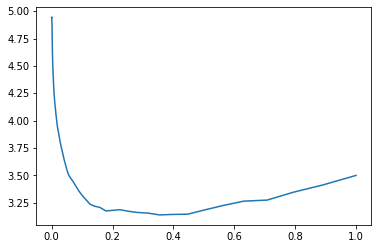

In [245]:
learning_rates, losses = search_learning_rate(trainer,end_lr=1.0)
losses = _smooth(losses, 0.98)
plt.plot(learning_rates, losses)

In [247]:

trainer.train()

INFO:allennlp.training.trainer:Beginning training.
INFO:allennlp.training.trainer:Epoch 0/9
INFO:allennlp.training.trainer:Worker 0 memory usage: 2.0G
INFO:allennlp.training.trainer:Training



INFO:allennlp.training.callbacks.console_logger:                       Training |  Validation
INFO:allennlp.training.callbacks.console_logger:loss               |     4.229  |       N/A
INFO:allennlp.training.callbacks.console_logger:worker_0_memory_MB |  2011.953  |       N/A
INFO:allennlp.training.trainer:Epoch duration: 0:03:25.164079
INFO:allennlp.training.trainer:Estimated training time remaining: 0:30:46
INFO:allennlp.training.trainer:Epoch 1/9
INFO:allennlp.training.trainer:Worker 0 memory usage: 2.0G
INFO:allennlp.training.trainer:Training



INFO:allennlp.training.callbacks.console_logger:                       Training |  Validation
INFO:allennlp.training.callbacks.console_logger:loss               |     3.227  |       N/A
INFO:allennlp.training.callbacks.console_logger:worker_0_memory_MB |  2011.953  |       N/A
INFO:allennlp.training.trainer:Epoch duration: 0:03:30.913043
INFO:allennlp.training.trainer:Estimated training time remaining: 0:27:44
INFO:allennlp.training.trainer:Epoch 2/9
INFO:allennlp.training.trainer:Worker 0 memory usage: 2.0G
INFO:allennlp.training.trainer:Training



INFO:allennlp.training.callbacks.console_logger:                       Training |  Validation
INFO:allennlp.training.callbacks.console_logger:loss               |     2.825  |       N/A
INFO:allennlp.training.callbacks.console_logger:worker_0_memory_MB |  2011.953  |       N/A
INFO:allennlp.training.trainer:Epoch duration: 0:03:22.982913
INFO:allennlp.training.trainer:Estimated training time remaining: 0:24:04
INFO:allennlp.training.trainer:Epoch 3/9
INFO:allennlp.training.trainer:Worker 0 memory usage: 2.0G
INFO:allennlp.training.trainer:Training



INFO:allennlp.training.callbacks.console_logger:                       Training |  Validation
INFO:allennlp.training.callbacks.console_logger:loss               |     2.932  |       N/A
INFO:allennlp.training.callbacks.console_logger:worker_0_memory_MB |  2011.953  |       N/A
INFO:allennlp.training.trainer:Epoch duration: 0:03:20.618250
INFO:allennlp.training.trainer:Estimated training time remaining: 0:20:29
INFO:allennlp.training.trainer:Epoch 4/9
INFO:allennlp.training.trainer:Worker 0 memory usage: 2.0G
INFO:allennlp.training.trainer:Training



INFO:allennlp.training.callbacks.console_logger:                       Training |  Validation
INFO:allennlp.training.callbacks.console_logger:loss               |     2.813  |       N/A
INFO:allennlp.training.callbacks.console_logger:worker_0_memory_MB |  2011.953  |       N/A
INFO:allennlp.training.trainer:Epoch duration: 0:04:08.285796
INFO:allennlp.training.trainer:Estimated training time remaining: 0:17:47
INFO:allennlp.training.trainer:Epoch 5/9
INFO:allennlp.training.trainer:Worker 0 memory usage: 2.0G
INFO:allennlp.training.trainer:Training



INFO:allennlp.training.callbacks.console_logger:                       Training |  Validation
INFO:allennlp.training.callbacks.console_logger:loss               |     2.686  |       N/A
INFO:allennlp.training.callbacks.console_logger:worker_0_memory_MB |  2011.953  |       N/A
INFO:allennlp.training.trainer:Epoch duration: 0:03:53.962907
INFO:allennlp.training.trainer:Estimated training time remaining: 0:14:27
INFO:allennlp.training.trainer:Epoch 6/9
INFO:allennlp.training.trainer:Worker 0 memory usage: 2.0G
INFO:allennlp.training.trainer:Training



INFO:allennlp.training.callbacks.console_logger:                       Training |  Validation
INFO:allennlp.training.callbacks.console_logger:loss               |     2.616  |       N/A
INFO:allennlp.training.callbacks.console_logger:worker_0_memory_MB |  2011.953  |       N/A
INFO:allennlp.training.trainer:Epoch duration: 0:03:51.353491
INFO:allennlp.training.trainer:Estimated training time remaining: 0:10:57
INFO:allennlp.training.trainer:Epoch 7/9
INFO:allennlp.training.trainer:Worker 0 memory usage: 2.0G
INFO:allennlp.training.trainer:Training



INFO:allennlp.training.callbacks.console_logger:                       Training |  Validation
INFO:allennlp.training.callbacks.console_logger:loss               |     2.714  |       N/A
INFO:allennlp.training.callbacks.console_logger:worker_0_memory_MB |  2011.953  |       N/A
INFO:allennlp.training.trainer:Epoch duration: 0:04:11.185855
INFO:allennlp.training.trainer:Estimated training time remaining: 0:07:26
INFO:allennlp.training.trainer:Epoch 8/9
INFO:allennlp.training.trainer:Worker 0 memory usage: 2.0G
INFO:allennlp.training.trainer:Training



INFO:allennlp.training.callbacks.console_logger:                       Training |  Validation
INFO:allennlp.training.callbacks.console_logger:loss               |     2.849  |       N/A
INFO:allennlp.training.callbacks.console_logger:worker_0_memory_MB |  2011.953  |       N/A
INFO:allennlp.training.trainer:Epoch duration: 0:04:26.263666
INFO:allennlp.training.trainer:Estimated training time remaining: 0:03:47
INFO:allennlp.training.trainer:Epoch 9/9
INFO:allennlp.training.trainer:Worker 0 memory usage: 2.0G
INFO:allennlp.training.trainer:Training



INFO:allennlp.training.callbacks.console_logger:                       Training |  Validation
INFO:allennlp.training.callbacks.console_logger:loss               |     2.851  |       N/A
INFO:allennlp.training.callbacks.console_logger:worker_0_memory_MB |  2011.953  |       N/A
INFO:allennlp.training.trainer:Epoch duration: 0:04:10.160830


{'best_epoch': 9,
 'peak_worker_0_memory_MB': 2011.953125,
 'training_duration': '0:38:20.903685',
 'training_start_epoch': 0,
 'training_epochs': 9,
 'epoch': 9,
 'training_loss': 2.851349238234163,
 'training_worker_0_memory_MB': 2011.953125}

In [248]:
from allennlp.commands.find_learning_rate import *

In [249]:
def predict(text: str, model: Model) -> float:
    tokens = reader._tokenizer.tokenize(text)
    instance = reader.text_to_instance(name=text, tokens=tokens)
    
    output = model.forward_on_instance(instance)
    print(output)

In [250]:
predict("chris", model)

{'loss': 4.3377275}


In [261]:
model.generate(initial_chars='rob')

('robživaaaaainaivaaaaaivovienaaaineaaaaaaivaaaaaaaaavaaanaaaaaieovaaaivovovovaivovov',
 0)

In [256]:
for _ in range(10):
    name, _ =model.generate()
    print(name)
    predict(name, model)

ef
{'loss': 1.5731012}
čaþelkaaeint
{'loss': 2.1716044}
şeinndun
{'loss': 1.8158191}
şeivomnnmnef
{'loss': 1.6486176}
čkşeivoivongülinkaaen
{'loss': 1.7685046}
č
{'loss': 1.6958929}
epeiva
{'loss': 1.907753}
leurat
{'loss': 1.9192063}
čpeitn
{'loss': 1.6688434}
čen
{'loss': 1.7267568}


In [145]:
predict("kristi",model)

{'loss': 2.627832}
